In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cài đặt và import thư viện

In [2]:
!pip install scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Đọc và xử lý dữ liệu

In [3]:
# Đọc dữ liệu từ Google Drive
df = pd.read_csv("/content/drive/MyDrive/IS403/DoAnCuoiKy/Dataset/VIX_Cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Tạo các đặc trưng đầu vào và mục tiêu
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
X = df[features]
y = df[target]
dates = df['Date']


# Hàm huấn luyện SVR, đánh giá và vẽ biểu đồ cho từng tỉ lệ

In [4]:
from sklearn.model_selection import GridSearchCV

def train_evaluate_svr(train_ratio, val_ratio, test_ratio):
    print("="*60)
    print(f"Tỷ lệ: Train {int(train_ratio*100)}% - Test {int(test_ratio*100)}% - Val {int(val_ratio*100)}%")

    # Normalize
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).ravel()

    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    X_train, X_val, X_test = X_scaled[:train_end], X_scaled[train_end:val_end], X_scaled[val_end:]
    y_train, y_val, y_test = y_scaled[:train_end], y_scaled[train_end:val_end], y_scaled[val_end:]
    date_train, date_val, date_test = dates[:train_end], dates[train_end:val_end], dates[val_end:]

    # GridSearchCV để tìm tham số tối ưu
    param_grid = {
        'C': [1, 10, 100],
        'epsilon': [0.001, 0.01, 0.1],
        'gamma': [0.01, 0.1, 1]
    }

    grid = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    print("→ Best Params:", grid.best_params_)

    # Huấn luyện mô hình tốt nhất
    model = grid.best_estimator_

    # Dự đoán
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    # Đánh giá
    def evaluate(y_true, y_pred):
        y_true = scaler_y.inverse_transform(y_true.reshape(-1,1)).ravel()
        y_pred = scaler_y.inverse_transform(y_pred.reshape(-1,1)).ravel()
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        return mae, mse, rmse, mape, r2, y_true, y_pred

    mae_v, mse_v, rmse_v, mape_v, r2_v, yv, ypv = evaluate(y_val, y_pred_val)
    mae_t, mse_t, rmse_t, mape_t, r2_t, yt, ypt = evaluate(y_test, y_pred_test)

    print("→ Testing:")
    print(f"  MAE: {mae_t:.2f}, MSE: {mse_t:.2f}, RMSE: {rmse_t:.2f}, MAPE: {mape_t:.2f}%, R²: {r2_t:.4f}")

    # Vẽ biểu đồ kết quả
    plt.figure(figsize=(15,6))
    plt.plot(date_train, scaler_y.inverse_transform(y_train.reshape(-1,1)), color='blue', label='Train')
    plt.plot(date_val, yv, color='green', label='Validation')
    plt.plot(date_test, yt, color='red', label='Test True')
    plt.plot(date_test, ypt, color='orange', linestyle='--', label='Test Predicted')
    plt.title(f'SVR ratio {int(train_ratio*100)}/{int(val_ratio*100)}/{int(test_ratio*100)}')
    plt.xlabel('Date')
    plt.ylabel('VIX price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, scaler_X, scaler_y

# Chạy mô hình cho các tỉ lệ

* **75/10/15**



Tỷ lệ: Train 75% - Test 15% - Val 10%
→ Best Params: {'C': 100, 'epsilon': 0.001, 'gamma': 0.1}
→ Testing:
  MAE: 82.32, MSE: 13539.96, RMSE: 116.36, MAPE: 0.73%, R²: 0.9882


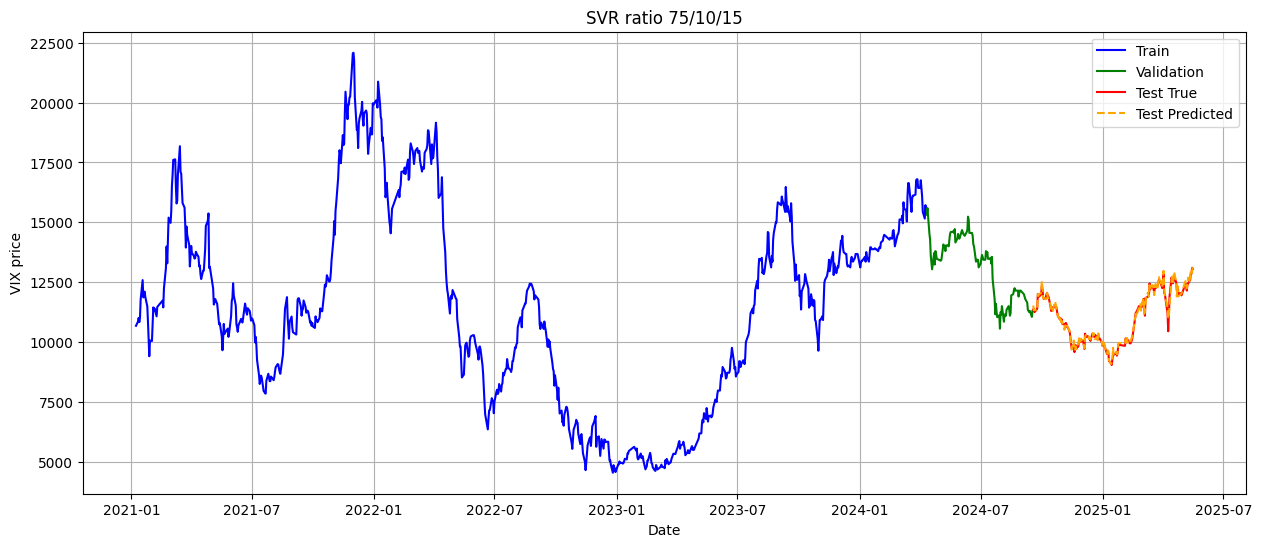

In [5]:
model_75, scX_75, scy_75 = train_evaluate_svr(0.75, 0.10, 0.15)

* **70/10/20**

Tỷ lệ: Train 70% - Test 20% - Val 10%
→ Best Params: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1}
→ Testing:
  MAE: 84.75, MSE: 12804.20, RMSE: 113.16, MAPE: 0.74%, R²: 0.9898


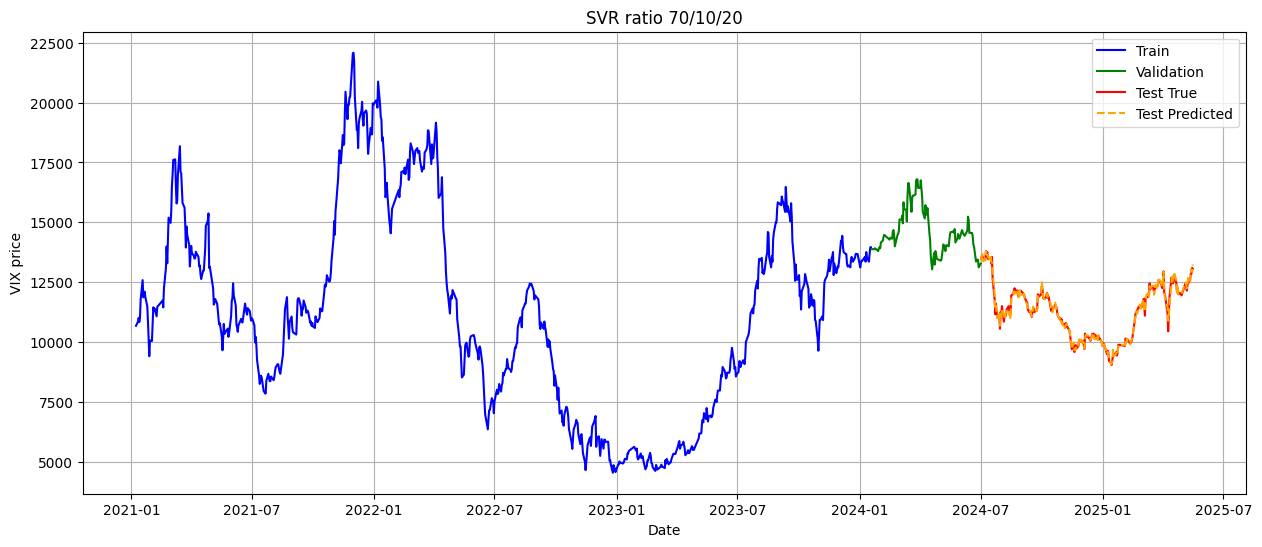

In [6]:
model_70, scX_70, scy_70 = train_evaluate_svr(0.70, 0.10, 0.20)

* **65/10/25**

Tỷ lệ: Train 65% - Test 25% - Val 10%
→ Best Params: {'C': 100, 'epsilon': 0.01, 'gamma': 0.1}
→ Testing:
  MAE: 99.03, MSE: 20434.60, RMSE: 142.95, MAPE: 0.82%, R²: 0.9914


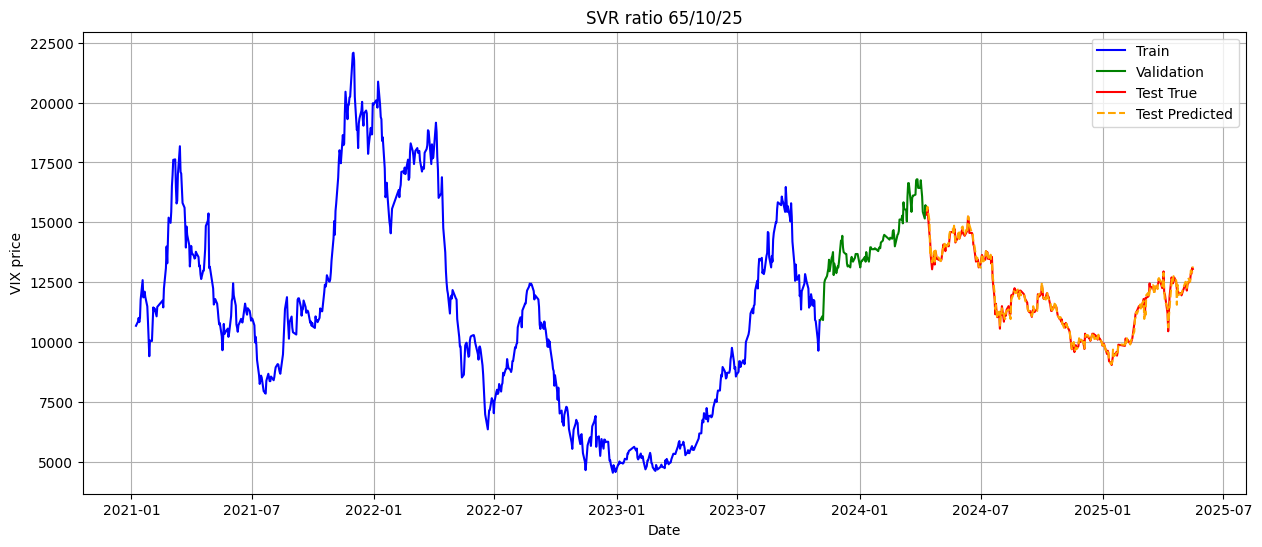

In [7]:
model_65, scX_65, scy_65 = train_evaluate_svr(0.65, 0.10, 0.25)

***->  Kết quả tốt nhất: 75/10/15***

# Dự đoán 30 ngày tiếp theo

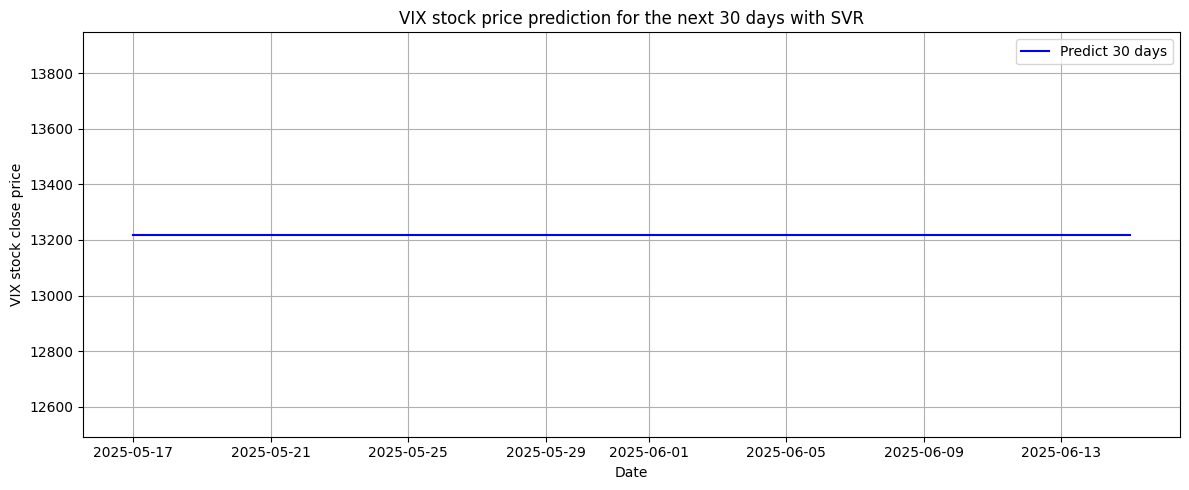

In [8]:
def predict_next_30_days_only(model, scaler_X, scaler_y, X, dates):
    # Lấy dữ liệu gần nhất
    recent_data = X.tail(1).copy()
    input_data = scaler_X.transform(recent_data).tolist()

    preds = []

    for _ in range(30):
        x = np.array(input_data[-1]).reshape(1, -1)
        pred_scaled = model.predict(x)[0]
        preds.append(pred_scaled)

        # Giả định rằng các đặc trưng (Open, High, Low, Volume) tiếp theo không đổi
        # hoặc bạn có thể cập nhật chúng dựa trên logic thực tế.
        # Ở đây, ta giữ nguyên input cuối làm giả định đơn giản.
        input_data.append(input_data[-1])

    # Biến đổi ngược để lấy giá trị thực
    y_preds = scaler_y.inverse_transform(np.array(preds).reshape(-1, 1)).ravel()

    # Tạo ngày tương lai
    last_date = dates.iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 5))
    plt.plot(future_dates, y_preds, label='Predict 30 days', color='blue', linestyle='-')
    plt.title("VIX stock price prediction for the next 30 days with SVR")
    plt.xlabel("Date")
    plt.ylabel("VIX stock close price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

predict_next_30_days_only(model_75, scX_75, scy_75, X, df['Date'])

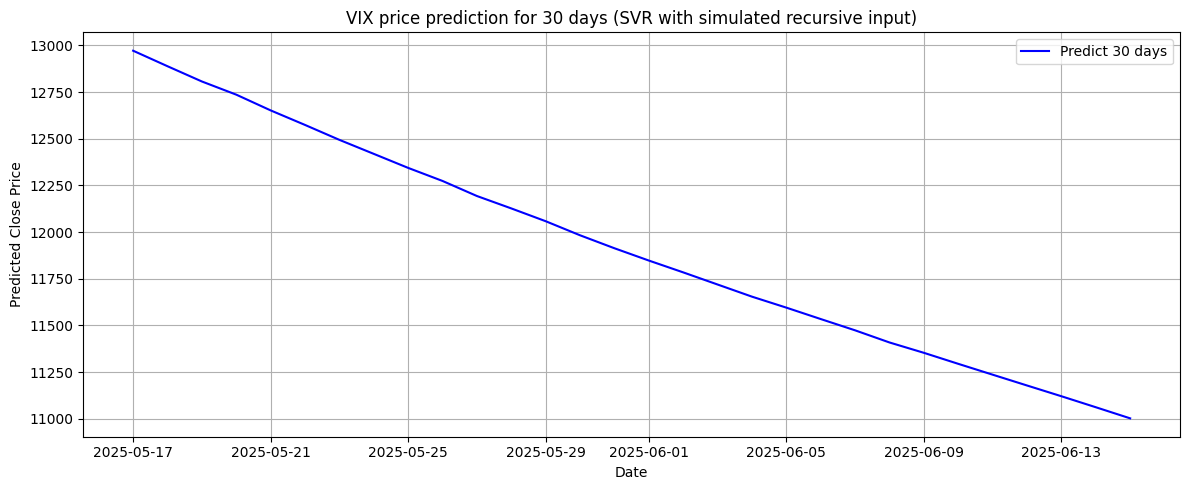

In [9]:
def predict_next_30_days_recursive(model, scaler_X, scaler_y, X, y, dates):
    last_row = X.iloc[-1].copy()
    last_close = y.iloc[-1]
    preds = []

    for _ in range(30):
        # Giả lập đặc trưng đầu vào
        simulated_open = last_close
        simulated_high = simulated_open * 1.01
        simulated_low = simulated_open * 0.99
        simulated_volume = last_row['Volume'] * (1 + np.random.normal(0, 0.02))  # 2% nhiễu

        new_row = pd.DataFrame([[simulated_open, simulated_high, simulated_low, simulated_volume]], columns=features)

        # Chuẩn hóa và dự đoán
        new_row_scaled = scaler_X.transform(new_row)
        pred_scaled = model.predict(new_row_scaled)[0]
        pred_close = scaler_y.inverse_transform([[pred_scaled]])[0][0]

        preds.append(pred_close)
        last_close = pred_close  # cập nhật close cho bước kế tiếp

    future_dates = pd.date_range(start=dates.iloc[-1] + pd.Timedelta(days=1), periods=30)

    plt.figure(figsize=(12, 5))
    plt.plot(future_dates, preds, label='Predict 30 days', color='blue')
    plt.title("VIX price prediction for 30 days (SVR with simulated recursive input)")
    plt.xlabel("Date")
    plt.ylabel("Predicted Close Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Gọi hàm dự đoán
predict_next_30_days_recursive(model_75, scX_75, scy_75, X, y, df['Date'])


In [15]:
!jupyter nbconvert --to html "/content/drive/MyDrive/IS403/DoAnCuoiKy/Code/SVR/SVR.ipynb" --output-dir="/content/drive/MyDrive/IS403/DoAnCuoiKy/Code/SVR"

[NbConvertApp] Converting notebook /content/drive/MyDrive/IS403/DoAnCuoiKy/Code/SVR/SVR.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 726754 bytes to /content/drive/MyDrive/IS403/DoAnCuoiKy/Code/SVR/SVR.html
